In [29]:
import os
import numpy as np
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import math
from collections import Counter
import pandas as pd

In [2]:
dataset_path = "C:/Users/Jenish/Desktop/dataset"

In [3]:
labels = ['normal', 'breathout', 'lowbreath']

mfcc_____spectral Centroid_____zero-crossing-rate

In [4]:
def extract_features(file_path):
    sample_rate, audio = wavfile.read(file_path)
    
    # Convert to floating-point
    audio = audio.astype(float)
    
    # Handle multi-channel audio
    if len(audio.shape) > 1:
        audio = audio[:, 0]  # Take the first channel
    
    # Normalize audio
    audio /= np.max(np.abs(audio))
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
    mfccs = np.mean(mfccs.T, axis=0)
    
    # Extract other features (e.g., spectral centroid, zero-crossing rate)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    spectral_centroid = np.mean(spectral_centroid)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    zero_crossing_rate = np.mean(zero_crossing_rate)
    
    # Combine features
    features = np.hstack([mfccs, spectral_centroid, zero_crossing_rate])
    
    return features

In [5]:
X = []
y = []
for label, label_name in enumerate(labels):
    label_path = os.path.join(dataset_path, label_name)
    for person in os.listdir(label_path):
        person_path = os.path.join(label_path, person)
        for file_name in os.listdir(person_path):
            file_path = os.path.join(person_path, file_name)
            features = extract_features(file_path)
            X.append(features)
            y.append(label)


In [6]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [7]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Class distribution:", Counter(y))

Shape of X: (1008, 22)
Shape of y: (1008,)
Class distribution: Counter({0: 336, 1: 336, 2: 336})


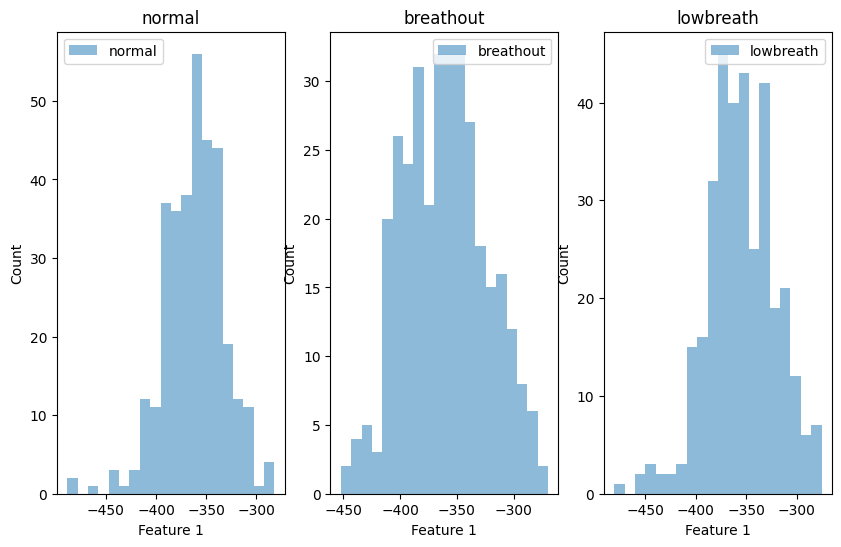

In [8]:
plt.figure(figsize=(10, 6))
for i, label_name in enumerate(labels):
    plt.subplot(1, 3, i + 1)
    plt.hist(X[y == i, 0], bins=20, alpha=0.5, label=label_name)
    plt.title(label_name)
    plt.xlabel('Feature 1')
    plt.ylabel('Count')
    plt.legend()
plt.show()

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
baseline_accuracy = max(Counter(y_train).values()) / len(y_train)
print(f'Baseline Accuracy: {baseline_accuracy * 100:.2f}%')

Baseline Accuracy: 33.87%


In [12]:
classifiers = [
    ('KNN', KNeighborsClassifier(n_neighbors=int(math.sqrt(len(X_train))), metric='manhattan')),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('SVM', SVC(kernel='rbf', gamma='auto', random_state=42))
]

In [16]:
classifier_scores = []
for name, classifier in classifiers:
    scores = cross_val_score(classifier, X_train, y_train, cv=5)
    classifier_scores.append((name, scores))
    print(f'{name} Accuracy: {scores.mean() * 100:.2f}% (+/- {scores.std() * 100:.2f}%)')
    # Train the classifier
    classifier.fit(X_train, y_train)
    # Predict labels
    y_pred = classifier.predict(X_test)
    # Print classification report
    print(f'Classification Report for {name}:')
    print(classification_report(y_test, y_pred, target_names=labels))

KNN Accuracy: 70.23% (+/- 3.52%)
Classification Report for KNN:
              precision    recall  f1-score   support

      normal       0.76      0.86      0.81        70
   breathout       0.76      0.72      0.74        69
   lowbreath       0.75      0.68      0.72        63

    accuracy                           0.76       202
   macro avg       0.76      0.75      0.75       202
weighted avg       0.76      0.76      0.76       202

Random Forest Accuracy: 80.40% (+/- 2.19%)
Classification Report for Random Forest:
              precision    recall  f1-score   support

      normal       0.83      0.93      0.88        70
   breathout       0.87      0.77      0.82        69
   lowbreath       0.84      0.84      0.84        63

    accuracy                           0.85       202
   macro avg       0.85      0.85      0.85       202
weighted avg       0.85      0.85      0.85       202

SVM Accuracy: 79.53% (+/- 3.24%)
Classification Report for SVM:
              precision   

In [17]:
best_classifier_name, best_classifier_scores = max(classifier_scores, key=lambda x: x[1].mean())
best_classifier = next(clf for name, clf in classifiers if name == best_classifier_name)
best_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
y_pred = best_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Classifier ({best_classifier_name}) Accuracy: {accuracy * 100:.2f}%')

Best Classifier (Random Forest) Accuracy: 84.65%


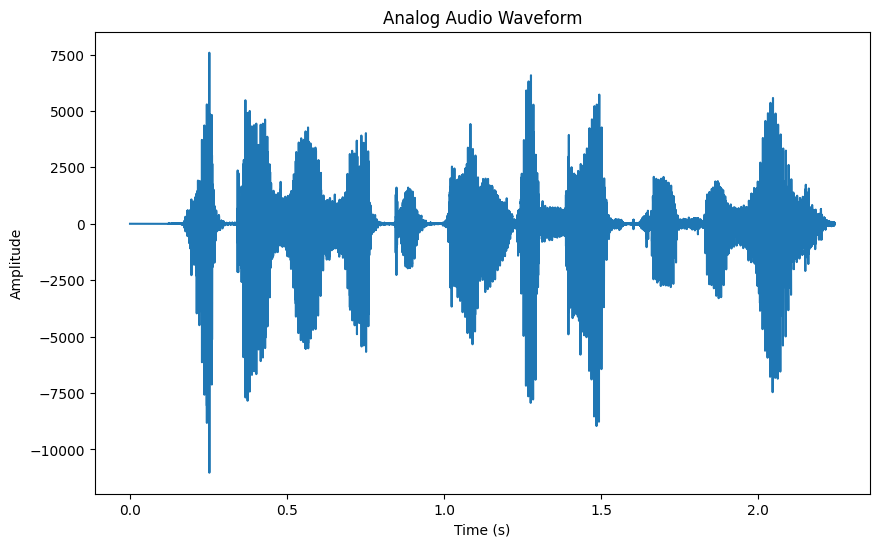

In [19]:
test_audio_files = []
for person in os.listdir(os.path.join(dataset_path, labels[y_test[0]])):
    person_path = os.path.join(dataset_path, labels[y_test[0]], person)
    test_audio_files.extend([os.path.join(person_path, file_name) for file_name in os.listdir(person_path)])

sample_audio_file = test_audio_files[0]
sample_rate, audio = wavfile.read(sample_audio_file)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(audio)) / sample_rate, audio)
plt.title('Analog Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('analog_waveform.png', dpi=300, bbox_inches='tight')
plt.show()

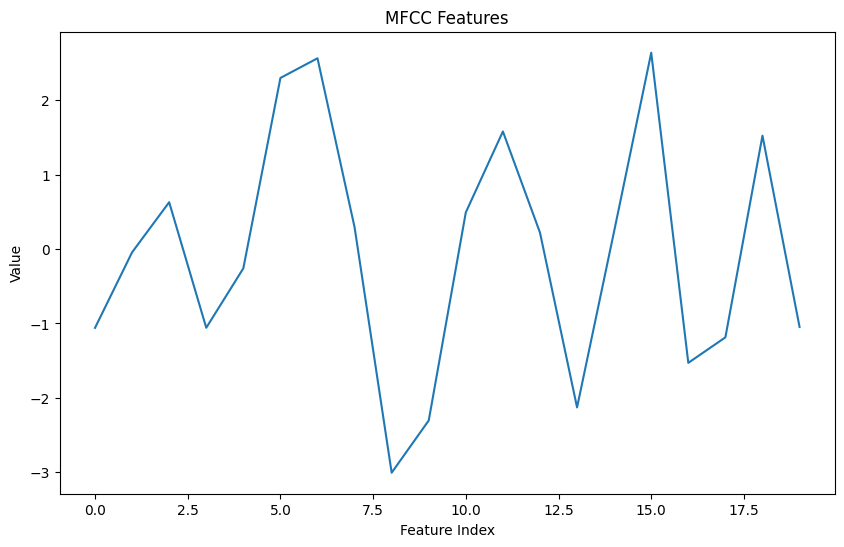

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(X_test[0, :20])
plt.title('MFCC Features')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.savefig('mfcc_features.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
class_accuracies = []
for label in range(len(labels)):
    class_mask = (y_test == label)
    class_y_true = y_test[class_mask]
    class_y_pred = y_pred[class_mask]
    class_accuracy = accuracy_score(class_y_true, class_y_pred)
    class_accuracies.append(class_accuracy)
    print(f'{labels[label]} Accuracy: {class_accuracy * 100:.2f}%')

normal Accuracy: 92.86%
breathout Accuracy: 76.81%
lowbreath Accuracy: 84.13%


In [23]:
labels = ['Class 1', 'Class 2', 'Class 3']

In [24]:
cm = confusion_matrix(y_test, y_pred)

In [35]:
cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
cm_normalized = cm_normalized.astype(int)  # Convert percentages to integers

In [36]:
df_cm = pd.DataFrame(cm_normalized, index=labels, columns=labels)

In [38]:
print("Confusion Matrix (%):\n")
print(df_cm)

Confusion Matrix (%):

         Class 1  Class 2  Class 3
Class 1       92        2        4
Class 2       13       76       10
Class 3        6        9       84
